# AdventureWorks Försäljningsanalys
Vi undersöker AdventureWorks data för att besvara affärsfrågor.

- Produktkategorier och försäljning
- Trender
- Segment

Vi använder SQL för att hämta data och Python för visualisering och analys

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus


user = "SA"
password = quote_plus("TimAjenR!1")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\timry\AppData\Local\Temp\ipykernel_102456\4029154932.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [3]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql),conn)

---
## Visualisering 1: Antal produkter per kategori
---
**Affärsfråga: Hur många produkter finns i varje kategori?**

*Använda tabeller*: 
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

*Plan*:
- Kombinera tabeller för att få fram önskad data
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultat


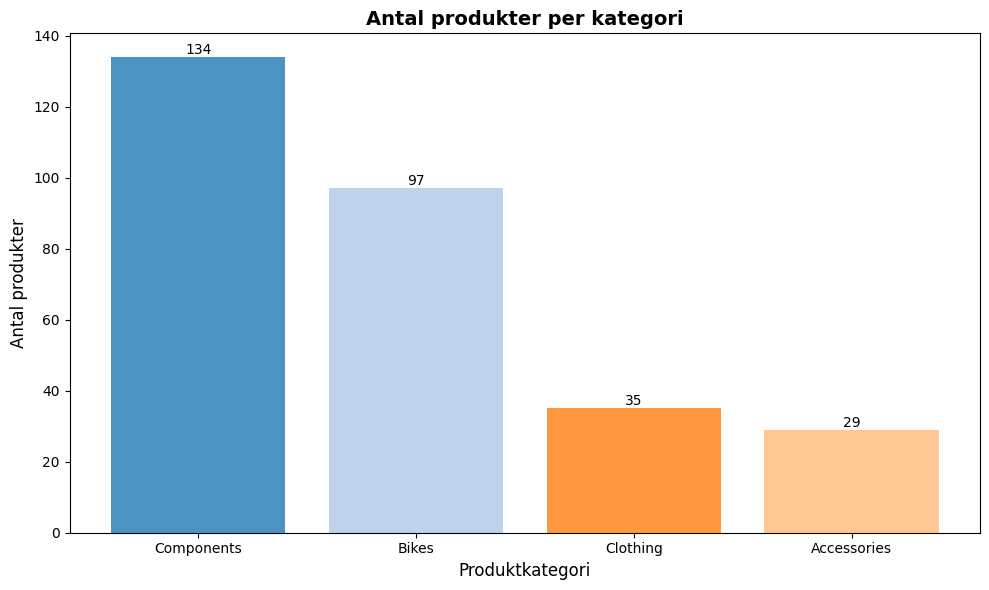

In [4]:
query_vis1 = """

SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC

"""

df_vis1 = query_df(query_vis1)

#Färger
colors = plt.cm.tab20(range(len(df_vis1)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'],color = colors, alpha = 0.8)

#Siffror
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha = 'center',
        va = 'bottom'
    )

# Titlar
ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal produkter', fontsize = 12)
ax.set_title('Antal produkter per kategori', fontsize = 14, fontweight = 'bold')

#Visa plot
plt.tight_layout()
plt.show()


### ***Insikter - Antal produkter per kategori***
Components har flest produkter på 134 st
Acccessories är minst med 29 produkter.

#### **Slutsats**:  
Företaget har en stor del komponenter och reservdelar. Troligtvis för att stötta deras näst största grupp som är cyklar.
Deras minsta diversifierade produktgrupp är accessories , kan vara ett segment som kan utvecklas.

---
# Visualisering 2: Försäljning per produktkategori
---
**Affärsfråga: Vilka produktkategorier genererar mest intäkter?**   

*Använda tabeller*: 
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

*Plan*:
- Kombinera tabeller för att få fram önskad data
- Med hjälp av aggregering och funktioner få fram önskad data
- Visualisera datan i horissotellt stapeldiagram
- Analysera resultatet.

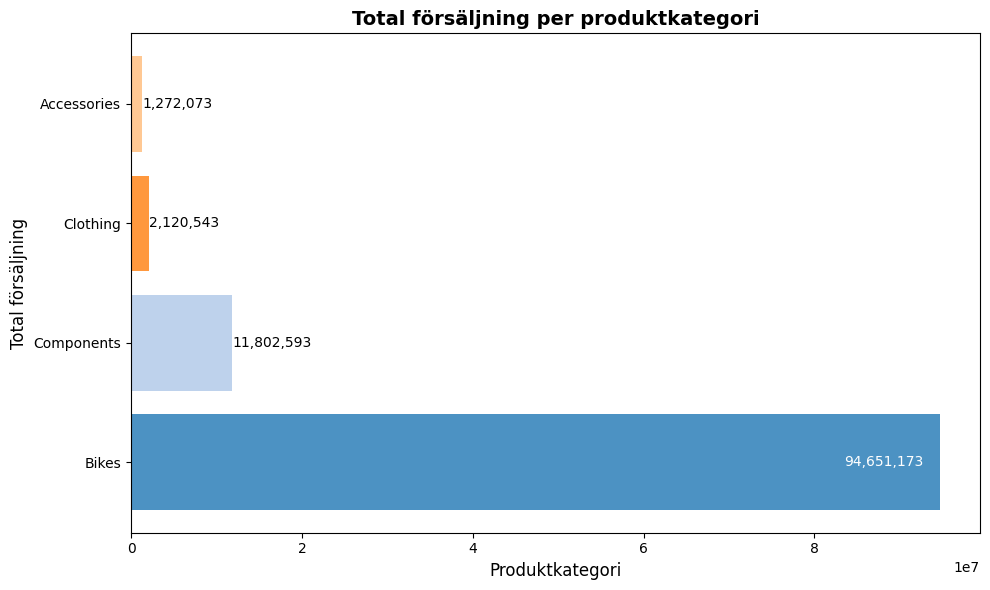

In [5]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""
df_vis2 = query_df(query_vis2)
#Färger
colors = plt.cm.tab20(range(len(df_vis2)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'],color = colors, alpha = 0.8)

#Siffror
max_value = df_vis2['TotalSales'].max()

for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    
    if width > 0.15 * max_value:
        x = width * 0.98
        ha = 'right'
        color = 'white'
    else:
        x = width * 1.01
        ha = 'left'
        color = 'black'

    ax.text(
        x,
        y,
        f'{width:,.0f}',
        va='center',
        ha=ha,
        color=color
    )
# Titlar
ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Total försäljning', fontsize = 12)
ax.set_title('Total försäljning per produktkategori', fontsize = 14, fontweight = 'bold')

#Visa plot
plt.tight_layout()
plt.show()


### ***Insikter - Försäljning per produktkategori***


Majoriteten av försäljningen kommer från "Bikes". 

- Total försäljning på 94.651.172 SEK vilket är ca 86,2% av den totala försäljningen
- Accessories står bara för 1,2% på en total av 1.272.072 SEK

---
# Visualisering 3: Försäljningstrend över tid
---
**Affärsfråga: Hur har försäljningen utvecklats över tid?**

*Använda tabeller*: 
- Sales.SalesOrderHeader   

*Plan*
- Med hjälp av aggregering och funktioner få fram önskad data
- Visalisera med ett linjediagram
- Analysera för trender


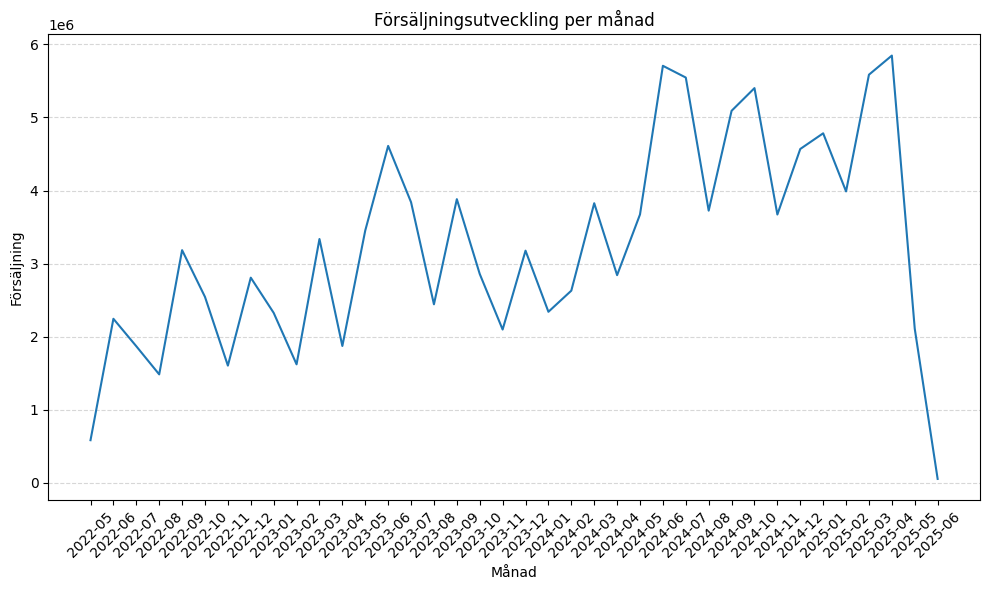

In [6]:
query_vis3 = """
SELECT
    FORMAT(OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(TotalDue) AS SalesAmount
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY OrderMonth;
"""

df_vis3 = query_df(query_vis3)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(df_vis3['OrderMonth'],df_vis3['SalesAmount'])

ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Etiketter och titel
ax.set_title("Försäljningsutveckling per månad")
ax.set_xlabel("Månad")
ax.set_ylabel("Försäljning")



# Rotera x-axelns etiketter för bättre läsbarhet
plt.xticks(rotation=45)

# Visa diagrammet
plt.tight_layout()
plt.show()





### **Insikter - Försäljning över tid**
Försäljningen har generellt ökat över perioden 2022–2025, med tydliga säsongsvariationer. 
- Den högsta månaden var april 2025
- Den lägsta var maj 2022. 
- Mönstret tyder på att försäljningen ofta är högre under vår och sommar och lägre under vintermånaderna.

---
# Visualisering 4: Försäljning och antal ordrar per år
---
**Affärsfråga**:   
Hur ser total försäljning och antal ordrar ut per år?   
   
*Använda tabeller*:   
• Sales.SalesOrderHeader   

*Plan*: 
- Med hjälp av aggregering och funktioner få fram önskad data  
- Visualisera resultat med ett grupperat stapeldiagram.
- Analysera resultatet

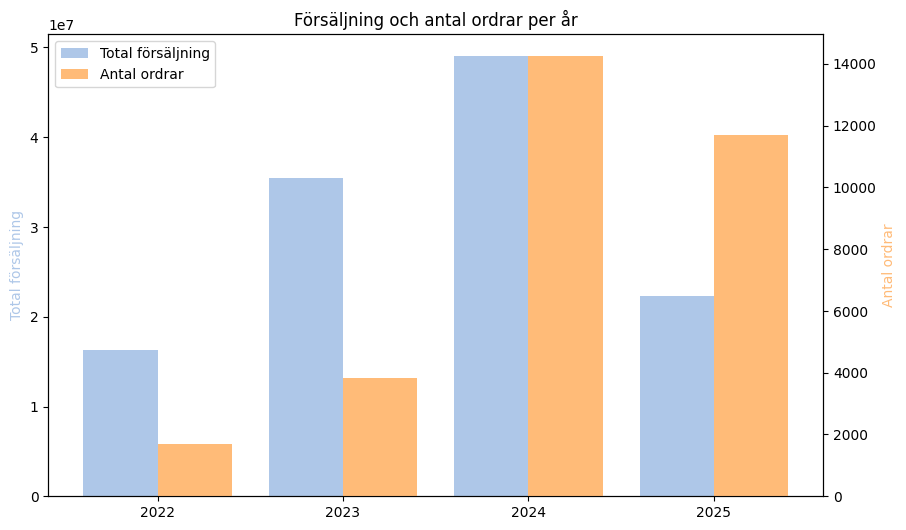

In [7]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(SalesOrderID) AS NbrOrders,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year;
"""

df_vis4 = query_df(query_vis4)

x = np.arange(len(df_vis4))  # positioner på x-axeln
width = 0.4

fig, ax1 = plt.subplots(figsize=(10,6))

# TotalSales som blå stapel
ax1.bar(x - width/2, df_vis4['TotalSales'], width, color=plt.cm.tab20(1), label='Total försäljning')
ax1.set_ylabel('Total försäljning', color=plt.cm.tab20(1))

# NbrOrders som röd stapel på sekundär y-axel
ax2 = ax1.twinx()
ax2.bar(x + width/2, df_vis4['NbrOrders'], width, color=plt.cm.tab20(3), label='Antal ordrar')
ax2.set_ylabel('Antal ordrar', color=plt.cm.tab20(3))

# X-axel etiketter
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['Year'])
plt.title('Försäljning och antal ordrar per år')

# Legend: kombinerar båda
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.show()


### **Insikter - Försäljning och antal orders per år**

Både försäljning och antal ordrar följer samma trend: ökande från 2022 → 2024, sedan en liten nedgång i antal ordrar 2025 men försäljning sjunker ännu mer.

- 2024 var det starkaste året både i försäljning och antal ordrar – toppår för företaget.

- 2025: även om antal ordrar fortfarande är högt (~12 000), minskar total försäljning kraftigt (~22 miljoner).

Detta tyder på lägre genomsnittligt ordervärde – fler men mindre ordrar. Alternativt så är datan för 2025 felaktig

---
### Visualisering 5: Top 10 produkter  
---    
**Affärsfråga**:  
Vilka 10 produkter genererar mest försäljning?   
 
*Använda tabeller*: 
- Production.Product
- Sales.SalesOrderDetail   

*Plan*:   
- Kombinera tabeller för att få fram önskad data
- Aggregera resultat 
- Visualisera resultat i horisontellt stapeldiagram
- Analysera data

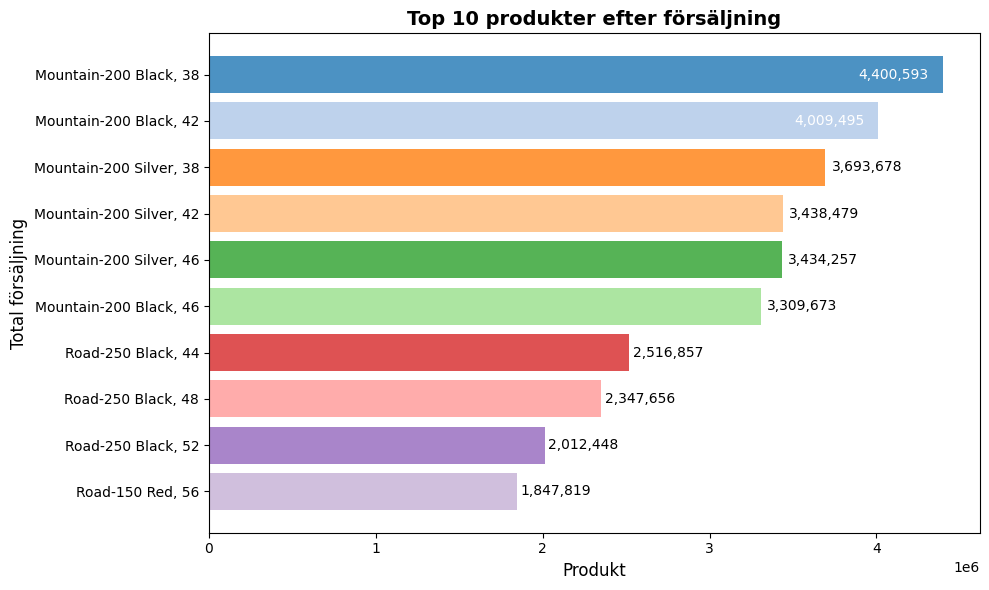

In [8]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""
df_vis5 = query_df(query_vis5)
#Färger
colors = plt.cm.tab20(range(len(df_vis5)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.barh(df_vis5['ProductName'], df_vis5['TotalSales'],color = colors, alpha = 0.8)

#Siffror
max_value = df_vis5['TotalSales'].max()

for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    
    if width > 0.9 * max_value:
        x = width * 0.98
        ha = 'right'
        color = 'white'
    else:
        x = width * 1.01
        ha = 'left'
        color = 'black'

    ax.text(
        x,
        y,
        f'{width:,.0f}',
        va='center',
        ha=ha,
        color=color
    )
# Titlar
ax.set_xlabel('Produkt', fontsize = 12)
ax.set_ylabel('Total försäljning', fontsize = 12)
ax.set_title('Top 10 produkter efter försäljning', fontsize = 14, fontweight = 'bold')

#Visa plot
ax.invert_yaxis()
plt.tight_layout()
plt.show()


### **Insikter - Top 10 produkter**
Samtliga 10 artiklar är inom kategorin "Bikes" och bästa produkten är "Mountain-200 BLACK,38" med en total försäljning på 4,400,592 SEK

---
### Visualisering 6: Försäljning och antal kunder per region
---   
**Affärsfråga**:   
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?   

*Använda tabeller*: 
- Sales.SalesTerritory, 
- Sales.SalesOrderHeader 
- Sales.Customer

*Plan*: 
- Kombinera tabeller för att få fram önskad data
- Aggregera resultat 
- Använda funktioner för att få fram önskat resultat
- Visualisera resultatet i grupperat stapeldiagram
- Analysera resultatet


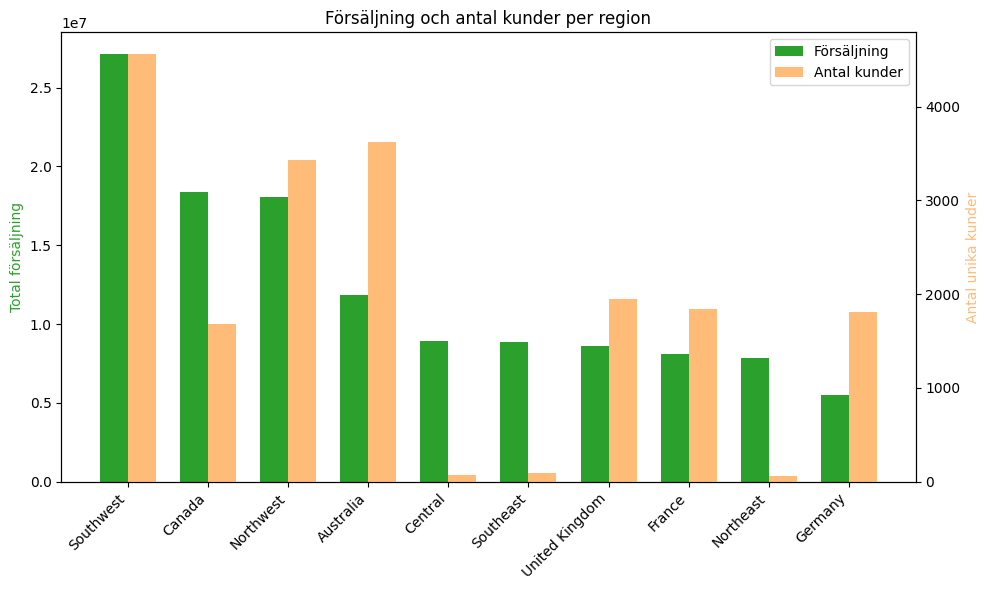

In [9]:
query_vis6 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""
df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stapel 1: Försäljning
ax1.bar(x - width/2, df_vis6["TotalSales"], width, label="Försäljning", color = plt.cm.tab20(4))
ax1.set_ylabel("Total försäljning",color = plt.cm.tab20(4))

# Stapel 2: Antal kunder (sekundär axel)
ax2 = ax1.twinx()
ax2.bar(x + width/2, df_vis6["UniqueCustomers"], width, label="Antal kunder", color = plt.cm.tab20(3))
ax2.set_ylabel("Antal unika kunder",color = plt.cm.tab20(3))

# X-axel
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6["Region"], rotation=45, ha="right")

# Titel
ax1.set_title("Försäljning och antal kunder per region")

# Gemensam legend

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')


plt.tight_layout()
plt.show()

### **Insikter - Försäljning och antal kunder per region**

Diagrammet visar försäljning (grön stapel) och antal unika kunder (orange stapel) för olika regioner.

##### **Starkaste och svagaste regioner**

- **Starkast (högst försäljning):**  
  *Central* – toppar både försäljning och kundantal.

- **Svagast (lägst försäljning):**  
  *Tyskland* – lägst i försäljning.

**Många kunder men låg omsättning**

Ni har några regioner med många kunder men lägre försäljning jämför med Southwest.

- Australia , Northwest, United Kingdom, France, Germany

Det tyder på lägre snittorder och fler mindre köp.

**Få kunder men hög omsättning**

Ni har även några regioner med få kunder men ändå någorlunda hög omsättning.

- Central, Southeast, Northeast

Det tyder på att området har ett fåtal kunder som står för majoriteten av omsättningen i områdena.


---
### Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
---   

**Affärsfråga**:   
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

*Använda tabeller*: 
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

*Plan*:
- Kombinera tabeller för önskat resultat
- Aggregera datan
- Med hjälp av funktioner få fram önskat resultat
- Visualisera datan med grupperat stapeldiagram
- Analysera resultatet  


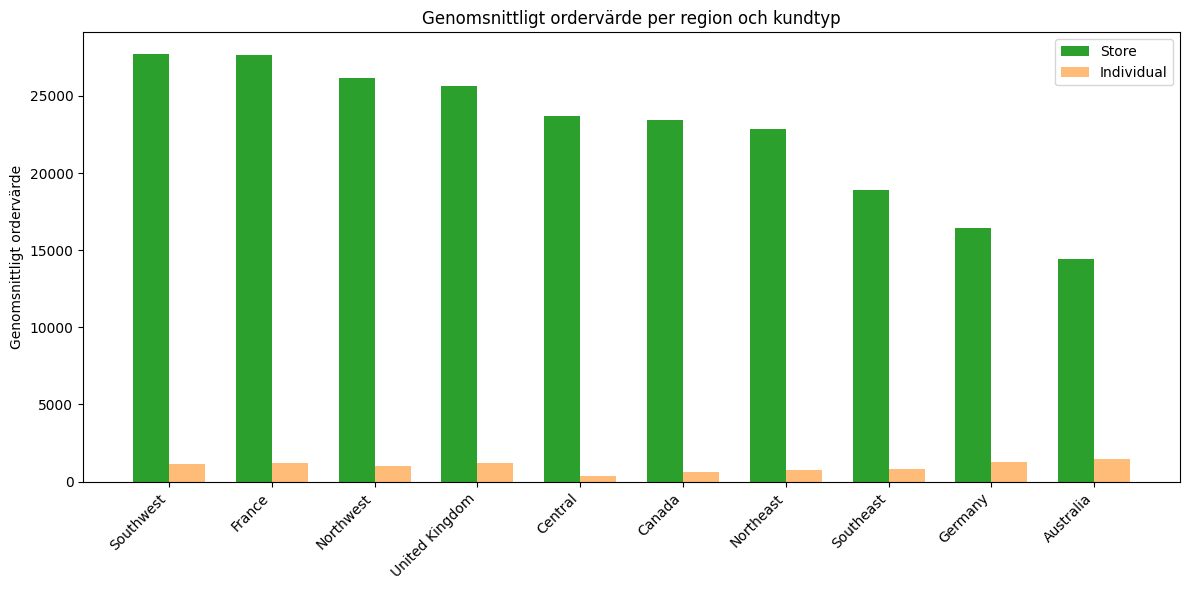

In [13]:
query_vis7 = """
SELECT
    t.Name AS Region,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    AVG(soh.TotalDue) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory t ON soh.TerritoryID = t.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY
    t.Name,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END
ORDER BY AVG(soh.TotalDue) DESC;
"""
df_vis7 = query_df(query_vis7)



region_totals = df_vis7.groupby("Region")["AvgOrderValue"].sum().sort_values(ascending=False)
regions_sorted = region_totals.index.tolist()  # Regioner sorterade från högst till lägst totalt

x = np.arange(len(regions_sorted))

width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Stapel 1: Store
ax.bar(
    x - width/2,
    df_vis7.loc[df_vis7["CustomerType"] == "Store"].set_index("Region").reindex(regions)["AvgOrderValue"],
    width,
    label="Store",
    color=plt.cm.tab20(4)
)

# Stapel 2 Individual
ax.bar(
    x + width/2,
    df_vis7.loc[df_vis7["CustomerType"] == "Individual"].set_index("Region").reindex(regions)["AvgOrderValue"],
    width,
    label="Individual",
    color=plt.cm.tab20(3)
)

# X-axel
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha="right")

# Y-axel och titel
ax.set_ylabel("Genomsnittligt ordervärde")
ax.set_title("Genomsnittligt ordervärde per region och kundtyp")

# Legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

### **Insikter - Genomsnittligt ordervärde per region och kundtyp**

Diagrammet visar genomsnittligt ordervärde för två kundtyper – **Store** (grön stapel) och **Individual** (orange stapel) – över olika regioner.


**Store vs Individual**

- Store-kunder har konsekvent högre ordervärde än Individual-kunder i alla regioner.
- Skillnaden är tydlig och ofta flera gånger högre.
- Australia sticker ut, där har Individual-kunder högre ordervärde än i andra regioner – kan tyda på annan köpbeteende eller produktmix.

**Möjliga orsaker**

- **Store-kunder** är sannolikt företag eller återförsäljare → större inköp per order.
- **Individual-kunder** handlar mindre, kanske mer frekvent men med lägre belopp.

**Slutsats**

- Store-kunder är nyckeln till högre intäkter per order.
- Regional strategi bör anpassas efter kundtypens beteende.
- Australia kan vara intressant för att förstå varför individer handlar mer där än i andra regioner.